<a href="https://www.kaggle.com/code/nikhilkushwaha2529/speech-command-recognition-rnn?scriptVersionId=156364245" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from time import sleep
from tqdm import tqdm
import os
import urllib.request
import pathlib
import shutil
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
import sys, os
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy 
import torch
# display
import IPython.display as ipd
from IPython.core.display import HTML
from IPython.display import display, clear_output
# audio library
import librosa.display 
import shutil


# 1. Introduction

The goal of this project is to implement an audio classification system, which: 
1. first reads in an audio clip (containing at most one word),
2. and then recognizes the class(label) of this audio.


### Classes  
7 classes are chosen, namely:   


In [2]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

device = xm.xla_device()


In [3]:
classes=[ "up", "down", "left", "right", "on", "off", "stop"]

where "yes" means the audio contains the word "yes", etc. 
### Method  

Features: MFCCs (Mel-frequency cepstral coefficients) are computed from the raw audio. You can think of it as the result of fouriour transformation.

Classifier: LSTM (Long Short-Term Memory) is adopted for classificatioin, which is a type of Recurrent Neural Network.

The model was pretrained on the [Speech Commands Dataset](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) with intensive data augmentation, including "shift", "amplify", "superpose noise", etc.     

## Step 2 Creation of some utility programs

We define some functions that allow us download the datasets that we need to use to create our ML model and train it.

In [4]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_file(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(
            url, filename=output_path, reporthook=t.update_to)

### 3.1.1. Speech Commands Dataset 
[Speech Commands Dataset](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) contains **105k audio clips** (3.3GB large) collected from lots of people.  
It has **35 classes** of words, listed as follows:  

In [5]:
# We define some parameters
# current working directory
DIR = os.path.abspath(os.getcwd())
DATASET_DIRECTORY_PATH = DIR+'/data/speech_commands'
#DOWNLOAD_URL = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
DOWNLOAD_URL = "http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz"

### Downloading the data and  Unzip the tar file

In [6]:
# Check if dataset directory already exist, otherwise download, extract and remove the archive
if not os.path.isdir(DATASET_DIRECTORY_PATH):
    if not os.path.isdir(DIR+'/data'):
        os.mkdir(DIR+'/data')
    print('Downloading from ' + DOWNLOAD_URL)
    download_file(DOWNLOAD_URL, DIR+'/data/speech_commands.tar.gz')
    print("Extracting archive...")
    shutil.unpack_archive(
        DIR+'/data/speech_commands.tar.gz', DATASET_DIRECTORY_PATH)
    os.remove(DIR+'/data/speech_commands.tar.gz')
    print("Done.")

speech_commands_v0.01.tar.gz: 1.49GB [00:04, 317MB/s]                            


Extracting archive...
Done.


In [7]:
# Delete the extra files of extracted file
# Cleaning data
if os.name == 'nt':
    print("We are on Windows")
    paths=DIR+'\data\speech_commands'
    os.chdir(paths)
    files=['testing_list.txt','validation_list.txt','LICENSE','README.md']
    for f in files:
        try:
            os.remove(f)
        except FileNotFoundError:
            continue
    #!dir
    os.chdir(DIR)
else:
    print("We are on Unix")
    extras=DIR+'/data/speech_commands/*.*'
    command='rm -rf '+ extras
    os.system(command)
    extras=DIR+'/data/speech_commands/LICENSE'
    command='rm -rf '+ extras
    os.system(command)
    #!ls ./data/speech_commands

We are on Unix


In [8]:
train_audio_path =DATASET_DIRECTORY_PATH+"/"

In [9]:
# Number of recording of each voices
labels = os.listdir(train_audio_path)
print(labels)

['one', 'two', 'off', 'house', 'cat', 'on', 'six', 'wow', 'yes', 'right', 'stop', 'five', 'no', 'bird', 'eight', 'four', 'tree', 'zero', 'bed', 'down', 'three', 'marvin', 'sheila', 'go', '_background_noise_', 'nine', 'up', 'dog', 'left', 'seven', 'happy']


In [10]:
to_remove = [x for x in labels if x not in classes]

In [11]:
len(to_remove)

24

In [12]:
print(to_remove)

['one', 'two', 'house', 'cat', 'six', 'wow', 'yes', 'five', 'no', 'bird', 'eight', 'four', 'tree', 'zero', 'bed', 'three', 'marvin', 'sheila', 'go', '_background_noise_', 'nine', 'dog', 'seven', 'happy']


In [13]:
for directory in to_remove:
    noise_dir_new=DIR+'/data/'+directory
    noise_dir_old=DIR+'/data/speech_commands/'+directory
    try:
        shutil.move(noise_dir_old, noise_dir_new)
    except FileNotFoundError as e:
        pass  #folder doesn't exist, deal with it.

In [14]:
# Number of recording of each voices
labels = os.listdir(train_audio_path)
print(labels)

['off', 'on', 'right', 'stop', 'down', 'up', 'left']


In [15]:
WORK_DIR =['data_train','checkpoints']
for DIRECTORY in WORK_DIR:
    WORK_DIRECTORY_PATH = DIR +'/'+ DIRECTORY 
    if not os.path.isdir(WORK_DIRECTORY_PATH):
        if not os.path.isdir(DIR+'/'+DIRECTORY ):
            os.mkdir(DIR+'/'+DIRECTORY )

In [16]:
CONFIG_DIRECTORY_PATH = DIR+'/config'
# Check if config directory already exist, otherwise will create
import os
import shutil
if not os.path.isdir(CONFIG_DIRECTORY_PATH):
    if not os.path.isdir(DIR+'/config'):
        os.mkdir(DIR+'/config')
    print('Creating config')
    # list of names
    names = labels
    # open file in write mode
    with open(r'config/classes.names', 'w') as fp:
        for item in names:
            # write each item on a new line
            fp.write("%s\n" % item)
    print("Done.")

Creating config
Done.


### Downloading the utils and installing

In [17]:
LIB_DIRECTORY_PATH = DIR+'/utils'
# Check if utils directory already exist, otherwise download, and install
import os
import shutil
if not os.path.isdir(LIB_DIRECTORY_PATH):
    if not os.path.isdir(DIR+'/utils'):
        os.mkdir(DIR+'/utils')
    print('Downloading utils')
    user = "ruslanmv"
    repo = "Speech-Recognition-with-RNN-Neural-Networks"
    src_dir = "utils"
    pyfile = "lib.py"
    url = f"https://raw.githubusercontent.com/{user}/{repo}/master/{src_dir}/{pyfile}"
    !wget --no-cache --backups=1 {url}
    print("Installing library...")
    shutil.move(DIR+'/lib.py', DIR +'/utils/lib.py')
    print("Done.")

--2023-12-25 00:29:37--  https://raw.githubusercontent.com/ruslanmv/Speech-Recognition-with-RNN-Neural-Networks/master/utils/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54761 (53K) [text/plain]
Saving to: ‘lib.py’

lib.py              100%[===================>]  53.48K  --.-KB/s    in 0.01s   

2023-12-25 00:29:37 (4.76 MB/s) - ‘lib.py’ saved [54761/54761]

Installing library...
Done.


In [18]:
try:
    import  gtts
except ImportError as e:
    !pip install gtts
    pass  # module doesn't exist, deal with it.


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [19]:
# Import all libraries
import utils.lib as lib

# 3. Methods

## 3.1. Training data   

These large amount of data are important for extracting the core features of a word.  
If I didn't do the pretraining on this dataset, the model will have poor performance when generalizing to other people's voices.

### 3.1.2. My dataset 
We choose 7 target classes listed as follows:  

In [20]:
# Number of recording of each voices
labels = os.listdir(train_audio_path)
print(labels)

['off', 'on', 'right', 'stop', 'down', 'up', 'left']


In [21]:
len(labels)

7

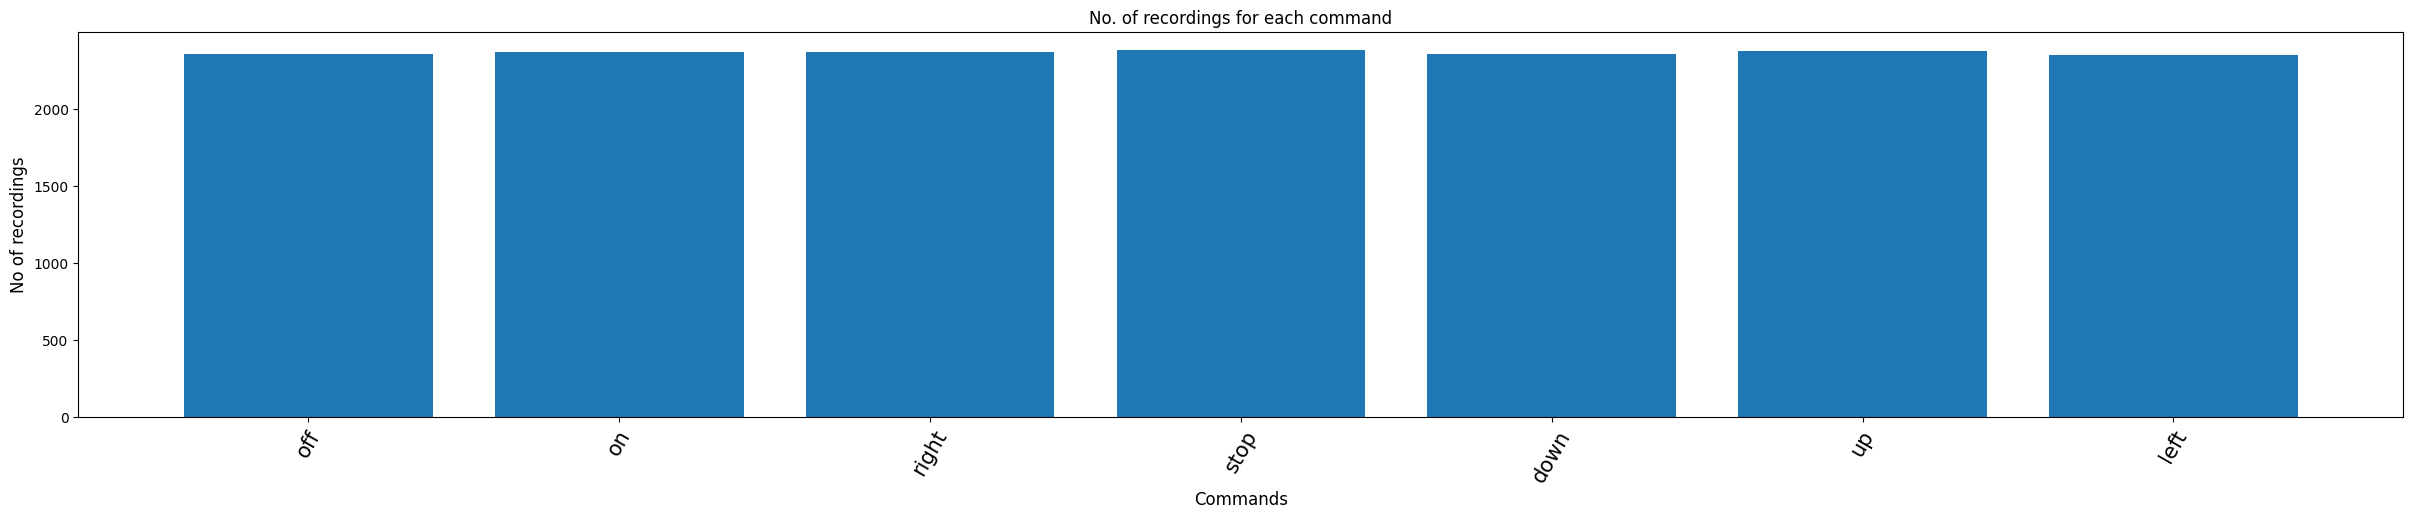

In [22]:
labels=os.listdir(train_audio_path)
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [23]:
#Load the audio file
if os.name == 'nt':
    print("We are on Windows")
    test_file=train_audio_path+'left/00b01445_nohash_0.wav'
    audio = lib.AudioClass(filename=test_file)
else:
    print("We are on Unix")
    test_file=train_audio_path+'left/00b01445_nohash_0.wav'
    audio = lib.AudioClass(filename=test_file)

We are on Unix


In [24]:
ipd.Audio(audio.data, rate=audio.sample_rate) # play audio

## 3.2. Data augmentation

Raw data goes through a serials of augmentation before training, including:  
> Shift  
> Pad zeros  
> Amplify  
> Change play speed  
> Superpose noise  

This step is essential. Raw audios in Speech Commands Dataset are all about 1 second long, and have little background noise. It can easily causes certain overfitting.  

We should try to diversify the data by data augmentation techniques, in order to get prepared for all kinds of real-world scenarios, including noise, variation of the audio length and loudness. 

**Example of audio augmentation:**

In [25]:
# Initialize the augmenter.
#     Specify a parameter's range for generating a random augmentation.

Aug = lib.Augmenter
aug = Aug([        
    
    Aug.Shift(rate=(0, 0.2), keep_size=False), # shift data for 0~0.2 percent of the total length
    
    Aug.PadZeros(time=(0, 0.3)),  # pad zeros at one side for 0~0.3 seconds 
    
    Aug.Amplify(rate=(0.2, 1.5)), # amplify loudness by 0.2~1.5 
    
    Aug.PlaySpeed(rate=(0.7, 1.3), keep_size=False), # change play speed
    
    Aug.Noise( # Superpose noise.
        # (Noise files are pre-load and normalized)
        noise_folder="data/_background_noise_/", prob_noise=1.0, intensity=(0, 0.7)),

], prob_to_aug=1.0, # probability to do this augmentation
)

**Noise files for audio augmentation:**

In [26]:
audio_noise = lib.AudioClass(filename="data/_background_noise_/doing_the_dishes.wav")
ipd.Audio(audio_noise.data, rate=audio_noise.sample_rate) # play audio

## 3.3. Features
The [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) feature is computed and fed into the classifer.

An intuitive understanding of MFCCs is: Use a sliding window on the raw data, and compute the fourior transform of each window to obtain the "loudness" on each frequency band.

The code and parameters for computing MFCCs is:

``` python
def compute_mfcc(data, sample_rate, n_mfcc=12):
    return librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=n_mfcc)
```

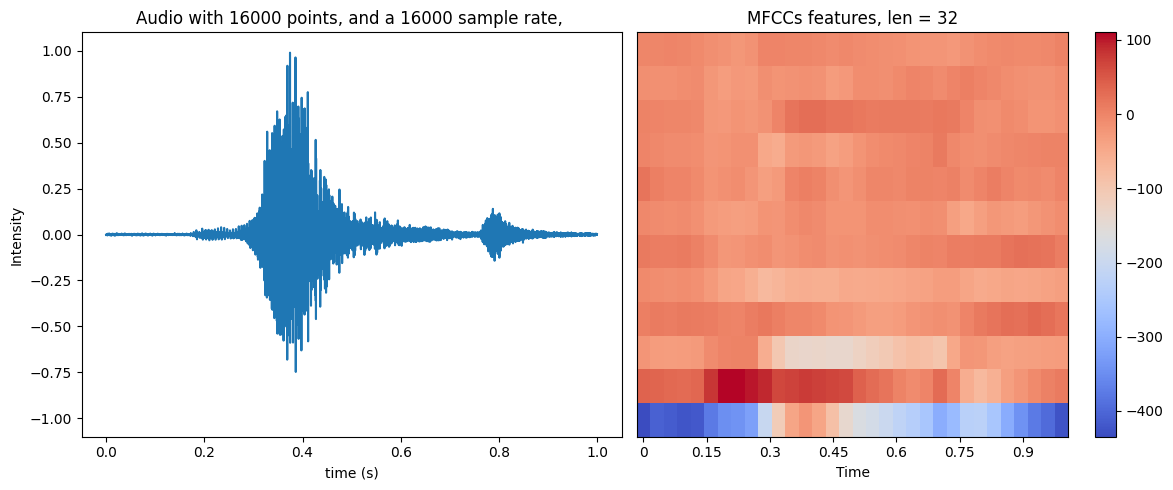

In [27]:
# A visualization of the MFCCs features is shown below:
audio.compute_mfcc()
audio.plot_audio_and_mfcc()
plt.show()

* Histogram of MFCCs is a bad feature  
I also tested the feature of "the histogram of MFCCs", but the performance is bad, since the information of time length is lost.  
A histogram feature is shown below. It's computed piece-wisely of 3 pieces on a MFCCs:

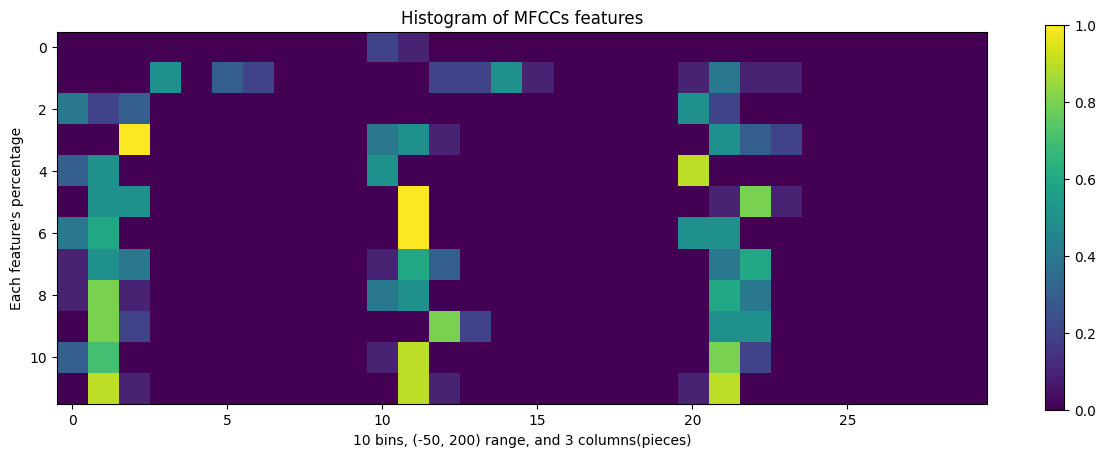

In [28]:
audio.compute_mfcc_histogram(bins=10, binrange=(-50, 200), col_divides=3)
audio.plot_mfcc_histogram() # After experiment, I found that this feature is bad. Don't use it.

# 3.4. Classifier
The input audio has a varying length, thus the feature's length also varies.  
To deal with such cases, I adopted the LSTM (Long short-term memory) for classification.  
The main paramters are set as: 3 layers and 64 states in each layer.  
The code is copied from [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/recurrent_neural_network/main.py).


In [29]:
import sys, os
ROOT=DATASET_DIRECTORY_PATH
sys.path.append(ROOT)
import numpy as np 
import torch 

In [30]:
import numpy as np 
import time
import types
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [31]:
def set_default_args():
    
    args = types.SimpleNamespace()

    # model params
    args.input_size = 12  # == n_mfcc
    args.batch_size = 1
    args.hidden_size = 64
    args.num_layers = 3

    # training params
    args.num_epochs = 100
    args.learning_rate = 0.0001
    args.learning_rate_decay_interval = 5 # decay for every 5 epochs
    args.learning_rate_decay_rate = 0.5 # lr = lr * rate
    args.weight_decay = 0.00
    args.gradient_accumulations = 16 # number of gradient accums before step
    
    # training params2
    args.load_weights_from = None
    args.finetune_model = False # If true, fix all parameters except the fc layer
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # data
    args.data_folder = "data/data_train/"
    args.train_eval_test_ratio=[0.9, 0.1, 0.0]
    args.do_data_augment = False

    # labels
    #args.classes_txt = "config/classes.names" 
    args.classes_txt =labels
    args.num_classes = None # should be added with a value somewhere, like this:
    #                = len(lib.read_list(args.classes_txt))

    # log setting
    args.plot_accu = True # if true, plot accuracy for every epoch
    args.show_plotted_accu = False # if false, not calling plt.show(), so drawing figure in background
    args.save_model_to = 'checkpoints/' # Save model and log file
        #e.g: model_001.ckpt, log.txt, log.jpg
    
    return args 

In [32]:
def load_weights(model, weights, PRINT=False):
    # Load weights into model.
    # If param's name is different, raise error.
    # If param's size is different, skip this param.
    # see: https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113/2
    
    for i, (name, param) in enumerate(weights.items()):
        model_state = model.state_dict()
        
        if name not in model_state:
            print("-"*80)
            print("weights name:", name) 
            print("RNN states names:", model_state.keys()) 
            assert 0, "Wrong weights file"
            
        model_shape = model_state[name].shape
        if model_shape != param.shape:
            print(f"\nWarning: Size of {name} layer is different between model and weights. Not copy parameters.")
            print(f"\tModel shape = {model_shape}, weights' shape = {param.shape}.")
        else:
            model_state[name].copy_(param)

In [33]:
def create_RNN_model(args, load_weights_from=None):
    ''' A wrapper for creating a 'class RNN' instance '''
    # Update some dependent args
    #args.num_classes = len(lib.read_list(args.classes_txt)) # read from "config/classes.names"
    args.num_classes = len(labels) # read from "config/classes.names"
    args.save_log_to = args.save_model_to + "log.txt"
    args.save_fig_to = args.save_model_to + "fig.jpg"
    
    # Create model
    device = args.device
    model = RNN(args.input_size, args.hidden_size, args.num_layers, args.num_classes, device).to(device)
    
    # Load weights
    if load_weights_from:
        print(f"Load weights from: {load_weights_from}")
        weights = torch.load(load_weights_from)
        load_weights(model, weights)
    
    return model

In [34]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, classes=None):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device
        self.classes = classes

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        '''Predict one label from one sample's features'''
        # x: feature from a sample, LxN
        #   L is length of sequency
        #   N is feature dimension
        x = torch.tensor(x[np.newaxis, :], dtype=torch.float32)
        x = x.to(self.device)
        outputs = self.forward(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        return predicted_index
    
    def set_classes(self, classes):
        self.classes = classes 
    
    def predict_audio_label(self, audio):
        idx = self.predict_audio_label_index(audio)
        assert self.classes, "Classes names are not set. Don't know what audio label is"
        label = self.classes[idx]
        return label

    def predict_audio_label_index(self, audio):
        audio.compute_mfcc()
        x = audio.mfcc.T # (time_len, feature_dimension)
        idx = self.predict(x)
        return idx


In [35]:
def evaluate_model(model, eval_loader, num_to_eval=-1):
    ''' Eval model on a dataset '''
    device = model.device
    correct = 0
    total = 0
    for i, (featuress, labels) in enumerate(eval_loader):

        featuress = featuress.to(device) # (batch, seq_len, input_size)
        labels = labels.to(device)

        # Predict
        outputs = model(featuress)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # stop
        if i+1 == num_to_eval:
            break
    eval_accu = correct / total
    print('  Evaluate on eval or test dataset with {} samples: Accuracy = {}%'.format(
        i+1, 100 * eval_accu)) 
    return eval_accu

In [36]:
def fix_weights_except_fc(model):
    not_fix = "fc"
    for name, param in model.state_dict().items():
        if not_fix in name:
            continue
        else:
            print(f"Fix {name} layer", end='. ')
            param.requires_grad = False
    print("")

In [37]:
def train_model(model, args, train_loader, eval_loader):

    device = model.device
    logger = lib.TrainingLog(training_args=args)
    if args.finetune_model:
        fix_weights_except_fc(model)
        
    # -- create folder for saving model
    if args.save_model_to:
        if not os.path.exists(args.save_model_to):
            os.makedirs(args.save_model_to)
            
    # -- Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    optimizer.zero_grad()

    # -- For updating learning rate
    def update_lr(optimizer, lr):    
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # -- Train the model
    total_step = len(train_loader)
    curr_lr = args.learning_rate
    cnt_batches = 0
    for epoch in range(1, 1+args.num_epochs):
        cnt_correct, cnt_total = 0, 0
        for i, (featuress, labels) in enumerate(train_loader):
            cnt_batches += 1

            ''' original code of pytorch-tutorial:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            # we can see that the shape of images should be: 
            #    (batch_size, sequence_length, input_size)
            '''
            featuress = featuress.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(featuress)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            loss.backward() # error
            if cnt_batches % args.gradient_accumulations == 0:
                # Accumulates gradient before each step
                optimizer.step()
                optimizer.zero_grad()

            # Record result
            _, argmax = torch.max(outputs, 1)
            cnt_correct += (labels == argmax.squeeze()).sum().item()
            cnt_total += labels.size(0)
            
            # Print accuracy
            train_accu = cnt_correct/cnt_total
            if (i+1) % 50 == 0 or (i+1) == len(train_loader):
                print ('Epoch [{}/{}], Step [{}/{}], Loss = {:.4f}, Train accuracy = {:.2f}' 
                    .format(epoch, args.num_epochs, i+1, total_step, loss.item(), 100*train_accu))
            continue
        print(f"Epoch {epoch} completes")
        
        # -- Decay learning rate
        if (epoch) % args.learning_rate_decay_interval == 0:
            curr_lr *= args.learning_rate_decay_rate # lr = lr * rate
            update_lr(optimizer, curr_lr)
    
        # -- Evaluate and save model
        if (epoch) % 1 == 0 or (epoch) == args.num_epochs:
            eval_accu = evaluate_model(model, eval_loader, num_to_eval=-1)
            if args.save_model_to:
                name_to_save = args.save_model_to + "/" + "{:03d}".format(epoch) + ".ckpt"
                torch.save(model.state_dict(), name_to_save)
                print("Save model to: ", name_to_save)

            # logger record
            logger.store_accuracy(epoch, train=train_accu, eval=eval_accu)
            logger.save_log(args.save_log_to)
            
            # logger Plot
            if args.plot_accu and epoch == 1:
                plt.figure(figsize=(10, 8))
                plt.ion()
                if args.show_plotted_accu:
                    plt.show()
            if (epoch == args.num_epochs) or (args.plot_accu and epoch>1):
                logger.plot_train_eval_accuracy()
                if args.show_plotted_accu:
                    plt.pause(0.01) 
                plt.savefig(fname=args.save_fig_to)
        
        # An epoch end
        print("-"*80 + "\n")
    
    # Training end
    return

In [38]:
# Set arguments ------------------------- 
args = set_default_args()
args.learning_rate = 0.001
args.num_epochs = 25
args.learning_rate_decay_interval = 5 # decay for every 3 epochs
args.learning_rate_decay_rate = 0.5 # lr = lr * rate
args.do_data_augment = True
args.train_eval_test_ratio=[0.9, 0.1, 0.0]

In [39]:
# current working directory
DIR = os.path.abspath(os.getcwd())
DATASET_DIRECTORY_PATH = DIR+'/data/speech_commands'
args.data_folder = "data/speech_commands/"
args.classes_txt = "config/classes.names"
args.load_weights_from = None

In [40]:
# Dataset -------------------------- 
# Get data's filenames and labels
files_name, files_label = lib.AudioDataset.load_filenames_and_labels(
    args.data_folder, args.classes_txt)

Load data from:  data/speech_commands/
	Classes:  off, on, right, stop, down, up, left


In [41]:
DEBUG = False

In [42]:
# DEBUG: use only a subset of all data
if DEBUG == True:
    GAP = 1000
    files_name = files_name[::GAP]
    files_label = files_label[::GAP]
    args.num_epochs = 5
    print('We consider subset of dataset')
else:
    print('We consider the full dataset')

We consider the full dataset


In [43]:
# Set data augmentation
if args.do_data_augment:
    Aug = lib.Augmenter # rename
    aug = Aug([        
        Aug.Shift(rate=0.2, keep_size=False), 
        Aug.PadZeros(time=(0, 0.3)),
        Aug.Amplify(rate=(0.2, 1.5)),
        # Aug.PlaySpeed(rate=(0.7, 1.3), keep_size=False),
        Aug.Noise(noise_folder="data/_background_noise_/", 
                        prob_noise=0.7, intensity=(0, 0.7)),
    ], prob_to_aug=0.8)
else:
    aug = None

In [44]:
# Split data into train/eval/test
tr_X, tr_Y, ev_X, ev_Y, te_X, te_Y = lib.split_train_eval_test(
    X=files_name, Y=files_label, ratios=args.train_eval_test_ratio, dtype='list')
train_dataset = lib.AudioDataset(files_name=tr_X, files_label=tr_Y, transform=aug)
eval_dataset = lib.AudioDataset(files_name=ev_X, files_label=ev_Y, transform=None)

Split data into [Train=14902 (90.0%), Eval=1656 (10.0%),  Test=0 (0.0%)]


In [45]:
len(tr_X),len(tr_Y)

(14902, 14902)

In [46]:
len(ev_X),len( ev_Y )

(1656, 1656)

In [47]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=args.batch_size, shuffle=True)

In [48]:
print(torch.cuda.device_count())

0


In [49]:
cuda0 = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch [1/25], Step [50/14902], Loss = 1.8410, Train accuracy = 12.00
Epoch [1/25], Step [100/14902], Loss = 2.1007, Train accuracy = 12.00
Epoch [1/25], Step [150/14902], Loss = 1.9582, Train accuracy = 14.67
Epoch [1/25], Step [200/14902], Loss = 2.1240, Train accuracy = 14.00
Epoch [1/25], Step [250/14902], Loss = 1.9845, Train accuracy = 14.40
Epoch [1/25], Step [300/14902], Loss = 2.1266, Train accuracy = 16.00
Epoch [1/25], Step [350/14902], Loss = 1.7957, Train accuracy = 16.00
Epoch [1/25], Step [400/14902], Loss = 1.9083, Train accuracy = 16.25
Epoch [1/25], Step [450/14902], Loss = 1.9092, Train accuracy = 15.33
Epoch [1/25], Step [500/14902], Loss = 1.8994, Train accuracy = 14.60
Epoch [1/25], Step [550/14902], Loss = 1.8825, Train accuracy = 15.45
Epoch [1/25], Step [600/14902], Loss = 2.0226, Train accuracy = 16.33
Epoch [1/25], Step [650/14902], Loss = 1.8926, Train accuracy = 16.31
Epoch [1/25], Step [700/14902], Loss = 1.9727, Train accuracy = 17.00
Epoch [1/25], Step [7

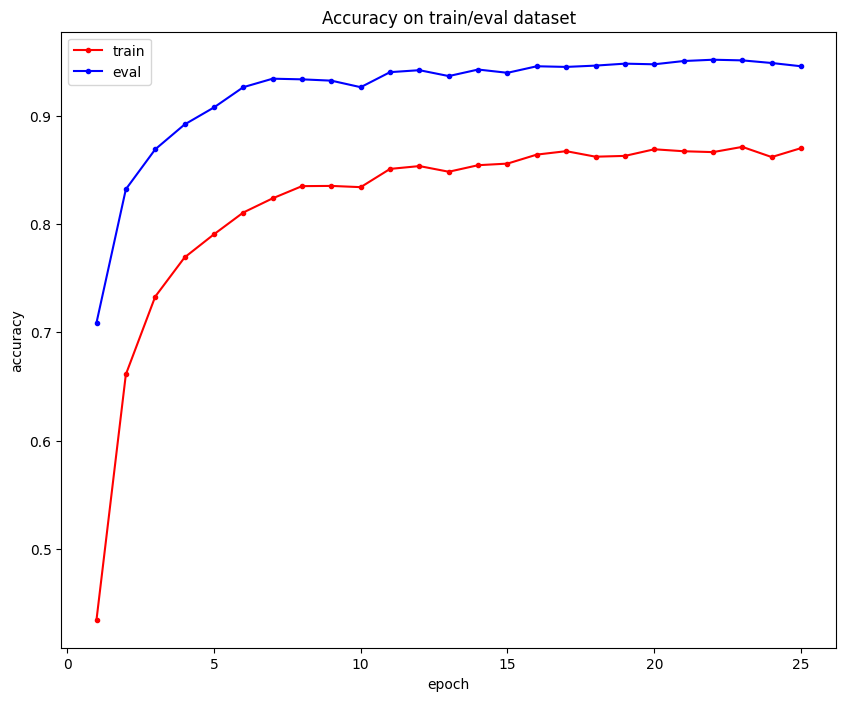

In [50]:
# Create model and train -------------------------------------------------
model = create_RNN_model(args, load_weights_from=args.load_weights_from) # create model
train_model(model, args, train_loader, eval_loader)

# 6. Test
Let's test the model on an audio file:

In [51]:
# Load model

def setup_classifier(load_weights_from):
    model_args = set_default_args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = create_RNN_model(model_args, load_weights_from)
    return model

def setup_classes_labels(load_classes_from, model):
    classes = lib.read_list(load_classes_from)
    print(f"{len(classes)} classes: {classes}")
    model.set_classes(classes)

In [52]:
model = setup_classifier(load_weights_from="checkpoints//025.ckpt")
setup_classes_labels(load_classes_from="config/classes.names", model=model)

Load weights from: checkpoints//025.ckpt
7 classes: ['off', 'on', 'right', 'stop', 'down', 'up', 'left']


In [53]:
#Load test audio file
if os.name == 'nt':
    print("We are on Windows")
    test_file=  ev_X[0]
    audio = lib.AudioClass(filename=test_file)
else:
    print("We are on Unix")
    test_file=ev_X[3]
    audio = lib.AudioClass(filename=test_file)

We are on Unix


In [54]:
# Test on an audio
ipd.Audio(audio.data, rate=audio.sample_rate) # play audio

In [55]:
# Test on an audio 
model.predict_audio_label(audio)

'stop'

In [56]:
label = model.predict_audio_label(audio)
print(f"Predicted label is: {label}")

Predicted label is: stop


# Predictions on the validation data:

In [57]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [58]:
y_pred = []
y_true = []
for i in range(len(ev_X)):
    audio = lib.AudioClass(filename=ev_X[i])
    prediction=model.predict_audio_label(audio)
    y_pred.append(prediction)
    real=labels[ev_Y[i]]
    y_true.append(real)

In [59]:
# converting list to array
actual  = numpy.array(y_true)
predicted = numpy.array(y_pred)

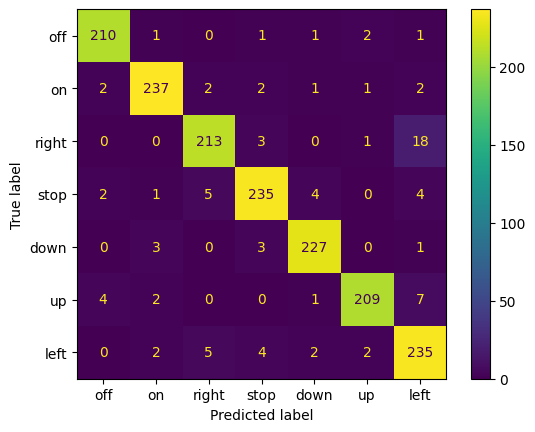

In [60]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()